# Feature engineering

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

from darts import TimeSeries
from darts.utils.missing_values import extract_subseries

from utils import holt_smoother

In [ ]:
def generate_datetime_ts(ts: TimeSeries) -> TimeSeries:
    """Generates time series of date time features using one hot encoding"""
    dayofweek = (
        pd.get_dummies(ts.time_index.day_of_week)
        .rename(columns=lambda x: f"dow_{x}")
        .set_index(ts.time_index)
    )
    hours = (
        pd.get_dummies(ts.time_index.hour)
        .rename(columns=lambda x: f"hour_{x}")
        .set_index(ts.time_index)
    )

    datetime_features = dayofweek.merge(
        hours, left_index=True, right_index=True
    ).astype(int)

    return TimeSeries.from_dataframe(datetime_features)


def generate_poly_ts(ts: TimeSeries, degree: int) -> TimeSeries:
    poly_values = PolynomialFeatures(degree, include_bias=False).fit_transform(
        ts.values()
    )
    poly_features = pd.DataFrame(
        poly_values,
        columns=[f"polyfeature_{i}" for i in range(poly_values.shape[1])],
        index=ts.time_index,
    )

    return TimeSeries.from_dataframe(
        poly_features,
        freq="h",
    )


def add_smoothed_precip(ts: TimeSeries, alpha: float) -> TimeSeries:
    lp_precip = holt_smoother(ts["acc_precip"].values().ravel(), alpha)
    ts_lp = TimeSeries.from_series(
        pd.Series(lp_precip, index=ts.time_index, name="smooth_precip")
    )
    return ts.concatenate(ts_lp, axis=1)


def pipeline(ts: TimeSeries) -> TimeSeries:
    alpha = 0.2  # smoothing coefficient
    deg = 3  # polynomial degree

    # We use our future precipitation observations as a "perfect forecast"
    future_components = [
        "acc_precip",
        "smooth_precip",
    ]

    ts = add_smoothed_precip(ts, alpha)
    ts1 = generate_poly_ts(ts[future_components], deg)
    ts2 = generate_datetime_ts(ts)

    return ts.drop_columns(future_components).concatenate(
        ts1.concatenate(ts2, axis=1), axis=1
    )

We transform the dataset by:
- Including a smoothed rain
    - The value of the parameter $\alpha$ is based on the correlation study in the [overview](./overview.ipynb) and simple trial and error to minimize forecasting error
- Including polynomial functions of the weather features
- Including datetime features, using one hot encoding

In [15]:
%run data_split.ipynb
data: pd.DataFrame = data  # type: ignore # noqa: F821
train_mask: pd.Series = train_mask  # type: ignore # noqa: F821
test_mask: pd.Series = test_mask  # type: ignore # noqa: F821

- These variables have a big gap at the end. Since we have other temperature measurements, e.g. `mean_temp` and `temp_soil_10`, we discard the following to preserve as many samples as possible.

In [16]:
data.drop(columns=["temp_grass", "temp_soil_30"], inplace=True)

- Splitting between train and test based on this [notebook](./data_split.ipynb).

In [17]:
train_data = data[train_mask].copy()
test_data = data[test_mask].copy()

- For convenience, we use darts `TimeSeries` and extract continuous data chunks. Also, we discard periods that are too short.

In [18]:
train_ts = TimeSeries.from_dataframe(train_data, freq="h")
subseries = extract_subseries(train_ts, mode="any")

min_length = 24 * 7  # 7 days
subseries = [s for s in subseries if len(s) >= min_length]

test_ts = TimeSeries.from_dataframe(test_data)

Total number of train samples 6961


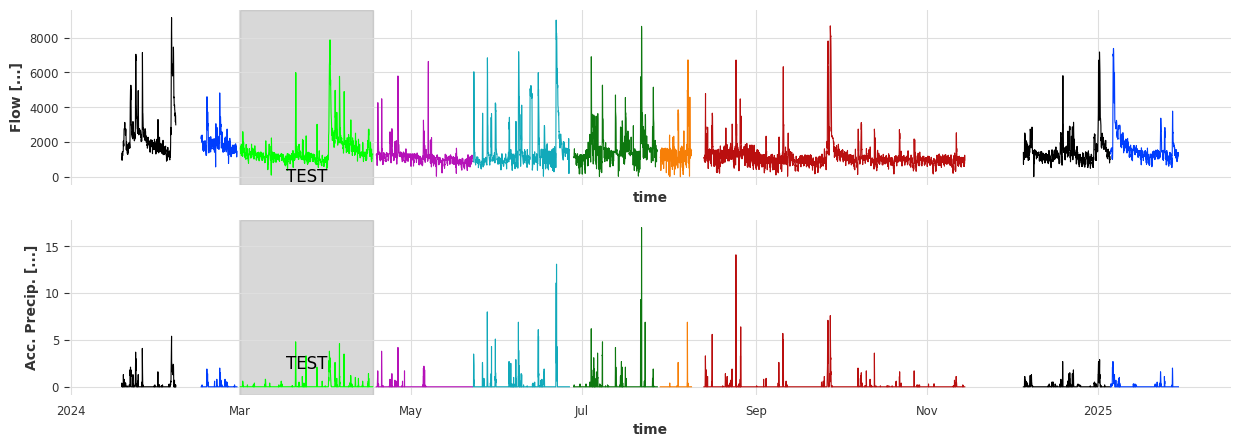

In [ ]:
print(f"Total number of train samples {sum([len(s) for s in subseries])}")
fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
for s in subseries:
    s["flow"].plot(ax=axes[0], linewidth=0.8)
    s["acc_precip"].plot(ax=axes[1], linewidth=0.8)


test_ts["flow"].plot(linewidth=0.8, ax=axes[0], color="lime")
test_ts["acc_precip"].plot(linewidth=0.8, ax=axes[1], color="lime")

start_test = test_ts.time_index[0]
end_test = test_ts.time_index[-1]

for j in [0, 1]:
    axes[j].axvspan(start_test, end_test, color="grey", alpha=0.3)
    axes[j].text(
        start_test + (end_test - start_test) / 2,
        2.5,
        "TEST",
        ha="center",
        va="center",
        fontsize=12,
    )

axes[0].legend().set_visible(False), axes[1].legend().set_visible(False)
axes[0].set_ylabel("Flow [m^3/h]"), axes[1].set_ylabel("Acc. Precip. [mm]");

- Splitting between target and covariates

In [20]:
target_subseries = [s["flow"] for s in subseries]
covariates_subseries = [s.drop_columns("flow") for s in subseries]

test_target = test_ts["flow"]
test_covariates = test_ts.drop_columns("flow")

In [21]:
expanded_covariates = []
for s in covariates_subseries:
    expanded_covariates.append(pipeline(s))

test_covariates = pipeline(test_covariates)

In [22]:
n_subseries = len(target_subseries)
n_features = expanded_covariates[0].n_components